# Classification of Supernovae (SN Ia vs Non-SN Ia)

###  Imports

In [ ]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score
)
from catboost import CatBoostClassifier
import os

###  Load and Inspect Data

In [9]:

# Load dataset
df_train = pd.read_csv('plasticc_train_data.csv')
df_test = pd.read_csv('plasticc_test_data.csv')

# Show unique transient types
print("Printing Transient Types:", df_train['type'].unique())

# Group all non-SN Ia as 'Non-SNIa'
df_train.loc[df_train['type'] != 'SN Ia', 'type'] = 'Non-SNIa'
df_test.loc[df_test['type'] != 'SN Ia', 'type'] = 'Non-SNIa'

Printing Transient Types: ['SN Ia' 'SN II' 'SLSN' 'SN Ibc' 'SN Ia-91bg' 'ILOT' 'CaRT' 'SN Iax' 'TDE'
 'Point source μ-lensing' 'PISN' 'Binary system μ-lensing']


###  Define Features and Labels

In [10]:

feature_cols = [
    'g_pk_mag','r_pk_mag', 'i_pk_mag', 'z_pk_mag', 'y_pk_mag',
    'g_alpha', 'g_beta', 'r_alpha', 'r_beta', 'i_alpha', 'i_beta',
    'z_alpha', 'z_beta', 'y_alpha', 'y_beta'
]
label_col = 'type'



###  Define Training, Validation and Test Set


In [11]:
x_train_val = df_train[feature_cols].to_numpy()
y_train_val = df_train[label_col].to_numpy()

x_test = df_test[feature_cols].to_numpy()
y_test = df_test[label_col].to_numpy()


x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.1, random_state=90
)

print('Training data size:', np.shape(x_train)[0])
print('Test data size:', np.shape(x_test)[0])
print('No. of features:', np.shape(x_train)[1])


Training data size: 8033
Test data size: 2232
No. of features: 15


### Train CatBoost with Multiple Seeds

In [ ]:

as1_t, ps_t, re_t, f1_t = [], [], [], [] ##Training
as1_v, ps_v, re_v, f1_v = [], [], [], [] ##Validation
as1, ps, re, f1 = [], [], [], []        ##Test

random_seed_list = [20, 90, 121, 165, 200]

for seed in random_seed_list:
    clf = CatBoostClassifier(verbose=False, random_seed=seed)
    classifier = clf.fit(x_train, y_train, eval_set=(x_val, y_val))

    # Predictions
    y_pred_train = classifier.predict(x_train)
    y_pred_val = classifier.predict(x_val)
    y_pred_test = classifier.predict(x_test)

    # Train metrics
    as1_t.append(accuracy_score(y_train, y_pred_train))
    ps_t.append(precision_score(y_train, y_pred_train, pos_label='SN Ia'))
    re_t.append(recall_score(y_train, y_pred_train, pos_label='SN Ia'))
    f1_t.append(f1_score(y_train, y_pred_train, pos_label='SN Ia'))

    # Validation metrics
    as1_v.append(accuracy_score(y_val, y_pred_val))
    ps_v.append(precision_score(y_val, y_pred_val, pos_label='SN Ia'))
    re_v.append(recall_score(y_val, y_pred_val, pos_label='SN Ia'))
    f1_v.append(f1_score(y_val, y_pred_val, pos_label='SN Ia'))

    # Test metrics
    as1.append(accuracy_score(y_test, y_pred_test))
    ps.append(precision_score(y_test, y_pred_test, pos_label='SN Ia'))
    re.append(recall_score(y_test, y_pred_test, pos_label='SN Ia'))
    f1.append(f1_score(y_test, y_pred_test, pos_label='SN Ia'))


###  Print Metrics (mean ± std)

In [14]:

def fmt(x):
    return f"{np.mean(x)*100:.1f}% ± {np.std(x)*100:.1f}%"

metrics = {
    'Train': [as1_t, ps_t, re_t, f1_t],
    'Validation': [as1_v, ps_v, re_v, f1_v],
    'Test': [as1, ps, re, f1]
}

names = ['Accuracy', 'Precision', 'Recall', 'F1-score']

for split, vals in metrics.items():
    print(f"{split}: " + ", ".join(f"{n}: {fmt(v)}" for n, v in zip(names, vals)))


Train: Accuracy: 99.6% ± 0.1%, Precision: 99.5% ± 0.2%, Recall: 99.9% ± 0.1%, F1-score: 99.7% ± 0.1%
Validation: Accuracy: 97.0% ± 0.0%, Precision: 96.0% ± 0.1%, Recall: 98.5% ± 0.1%, F1-score: 97.2% ± 0.0%
Test: Accuracy: 98.5% ± 0.0%, Precision: 97.8% ± 0.1%, Recall: 99.5% ± 0.1%, F1-score: 98.6% ± 0.0%


###  Confusion Matrix (last run)

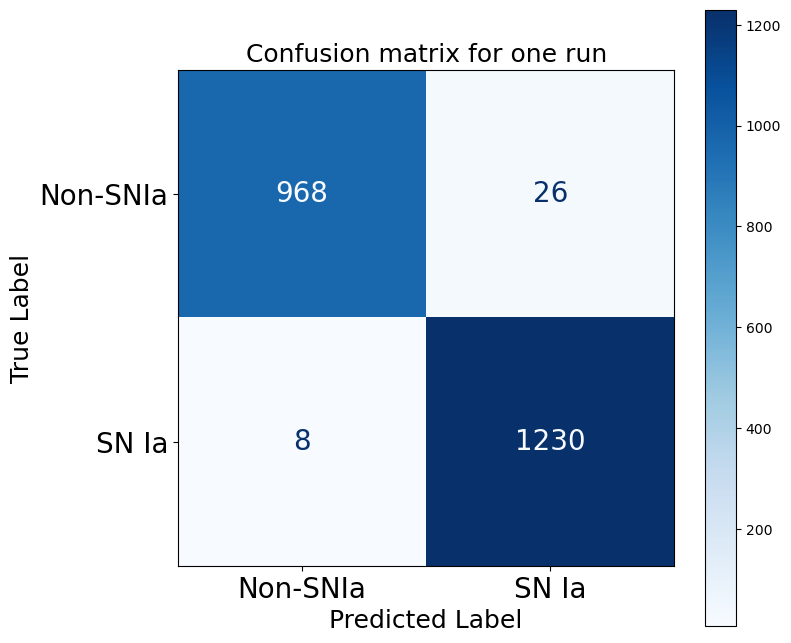

In [ ]:

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')

# Customize font sizes
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
for label in ax.texts:
    label.set_fontsize(20)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.title('Confusion matrix for one run', fontsize=18)
os.makedirs("Figures", exist_ok=True)
plt.savefig('Figures/Confusion_Matrix.png')
plt.show()
